<a href="https://colab.research.google.com/github/yepuv1/primality/blob/master/prime_numbers_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural netowork to test the primality of a number.

## Install libraries on the VM

In [0]:
!uname -a
!lsb_release -a
!apt install graphviz
!pip install -q pydot

## Import python libraries

In [2]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.12.0-rc2


In [3]:
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

1.12.0-rc2
Found GPU at: /device:GPU:0


In [4]:
import keras
import numpy as np
import math
from sympy import primerange, sieve, composite, prime

import pickle
import timeit

from PIL import Image, ImageColor
%matplotlib inline
import os

np.random.seed(1)

Using TensorFlow backend.


## Data preparation and utility functions

In [0]:
def convert_dec2bin(num_list,feature_size):
  p_x = None
  for p in num_list:
    pb = bin(p)[2:].zfill(32)
    li = [ int(i) for i in pb]
    a1 = np.array(li).reshape((feature_size,1))
    if p_x is None:
      p_x = a1
    else:
      p_x = np.concatenate((p_x, a1), axis=1)
  return p_x

def generate_sequence_primes(between):
  start, end = between
  p_num = [i for i in primerange(start, end)]
  return p_num, len(p_num)

def generate_random_primes(size, primes):
  le = len(primes)
  p_num = [primes[i] for i in np.random.randint(le , size=size)]
  return p_num, size

def generate_composite(size, primes_set):
  c_num = np.random.randint(10000000, size=size)
  c_num = set(c_num)
  c_num = c_num - primes_set
  return list(c_num), len(c_num)

def generate_x_y(primes=None, composites=None, feature_size=32, ):
  c_examples_size = 0
  c_x = None
  c_y = None
  p_examples_size = 0
  p_x = None
  p_y = None
  X = None
  Y = None
 
  if primes is not None :
    p_examples_size = len(primes)
    p_x = convert_dec2bin(primes, feature_size)
    p_y = np.ones(shape=(1,p_examples_size), dtype=np.int32)

  if composites is not None:
    c_examples_size = len(composites)
    c_x = convert_dec2bin(composites, feature_size)
    c_y = np.zeros(shape=(1,c_examples_size), dtype=np.int32)
  
  if c_x is not None and p_x is not None:
    X = np.concatenate((c_x, p_x), axis=1)
    size = p_examples_size + c_examples_size
    Y = np.append(c_y, p_y).reshape((1, size))
  elif p_x is not None:
    X = p_x
    Y = p_y
    size = p_examples_size
  elif c_x is not None:
    X = c_x
    Y = c_y
    size = c_examples_size
    
    
  return X, Y, size

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(dtype=tf.int32, name="C", value=C)
    one_hot_matrix = tf.one_hot(labels,depth=C, axis=0)
    with tf.Session() as sess:
      one_hot = sess.run(one_hot_matrix)
   
    return one_hot


  
def save_primes(file, start, end):
  p_num = [i for i in primerange(start, end)]
  pickle.dump( p_num, open(file, "wb" ))
  return p_num

def load_primes(file):
 return pickle.load(open(file, "rb" ))




## Generate the Primes

In [6]:
%%time
start = 2147483647 - 10000000
end = 2147483647
PRIMES_FILENAME = "primes1.p"
if not os.path.exists(PRIMES_FILENAME):
  PRIMES = save_primes(PRIMES_FILENAME, start, end)
else:
  PRIMES = load_primes(PRIMES_FILENAME)
print(len(PRIMES))

465816
CPU times: user 36.3 s, sys: 633 ms, total: 36.9 s
Wall time: 36.9 s


## Generate the Training and Test Datasets

In [0]:
examples_size = 5000
primes_set = set(PRIMES)
c, size = generate_composite(examples_size, primes_set)
p, size = generate_random_primes(examples_size,PRIMES)
s_p_train = set(p)
X_train, Y_train, training_size = generate_x_y(p,c)


examples_size = 100
c, size = generate_composite(examples_size, primes_set)
p, size = generate_random_primes(examples_size,PRIMES)

# remove the primes common for both test and train
s_p_test = set(p)
s_p_test = s_p_test - s_p_train
X_test, Y_test, test_size = generate_x_y(list(s_p_test),c)

Y_train = one_hot_matrix(Y_train.reshape(training_size), 2)
Y_test = one_hot_matrix(Y_test.reshape(test_size), 2)

In [8]:
print(X_train.T.shape)

(9999, 32)


## Model Creation and Training

In [9]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense


X_train.shape

# create model
model = Sequential()
model.add(Dense(64, input_dim=32, activation='relu',))
model.add(Dense(2, input_dim=64,activation='sigmoid'))
#model.add(Dense(2,input_dim=, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X_train.T, Y_train.T, validation_split=0.25, epochs=5, batch_size=10, verbose=1)
# evaluate the model
scores = model.evaluate(X_train.T, Y_train.T)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 7499 samples, validate on 2500 samples
Epoch 1/5
7499/7499 [==============================] - 6s 818us/step - loss: 0.0640 - acc: 0.9871 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2/5
7499/7499 [==============================] - 5s 705us/step - loss: 4.9445e-04 - acc: 1.0000 - val_loss: 1.9856e-04 - val_acc: 1.0000
Epoch 3/5
7499/7499 [==============================] - 5s 730us/step - loss: 1.5551e-04 - acc: 1.0000 - val_loss: 9.5011e-05 - val_acc: 1.0000
Epoch 4/5
7499/7499 [==============================] - 5s 708us/step - loss: 7.0929e-05 - acc: 1.0000 - val_loss: 4.5775e-05 - val_acc: 1.0000
Epoch 5/5
9999/9999 [==============================] - 1s 73us/step

acc: 100.00%


## Visualize the Model

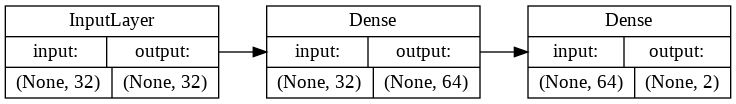

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='LR' )
from IPython.display import Image
Image(filename='model.png') 

## Visualize Model Accuracy

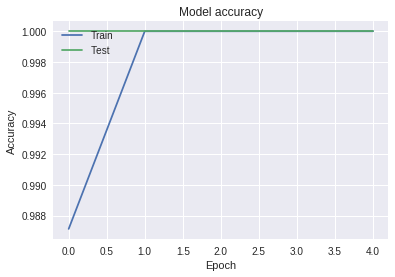

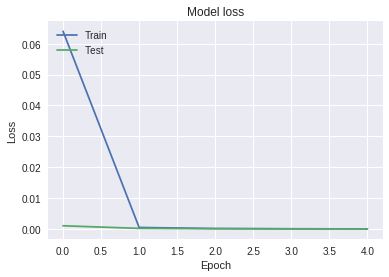

In [11]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluate the Test Datasets

In [12]:
scores = model.evaluate(X_test.T, Y_test.T)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

200/200 [==============================] - 0s 161us/step

acc: 100.00%


## Inference - Sequence test.

Check all to see if the model can accurately test for prime for all the PRIMES

In [13]:
p = np.array(PRIMES)
print(p.shape)
size = p.shape[0]

width = 500
for i in range(0,1000,width):
  x = p[i: i+width]
  X, Y, size = generate_x_y(x,None)
  Y = one_hot_matrix(Y.reshape(size), 2)
  scores = model.evaluate(X.T, Y.T)
  print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  

(465816,)
500/500 [==============================] - 0s 95us/step

acc: 100.00%
500/500 [==============================] - 0s 94us/step

acc: 100.00%
